In [1]:
import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, reduce
from tqdm import tqdm, trange
from torch.nn import functional as F
from utils.download_mnist import modified_mnist_dataloader_test, modified_mnist_dataloader_train, mnist_dataloader_train
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 
from experiment import OptiEBM

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def make_adaptive_experiment(config):
    ebm = make_energy_model(config, path=path)
    emb = ebm.to("cuda")
    adapt = OptiEBM(config, ebm)
    return adapt

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def pixelwise_varaince(imgs):
    ex = reduce(imgs, "b h w -> h w", "mean")
    ex2 = reduce(imgs**2, "b h w -> h w", "mean")
    return ex2 - ex**2

def reconstruction_error(x_hat, x, reduction="mean"):
    return F.mse_loss(x_hat, x, reduction=reduction)

In [2]:
model_name = "modified_mnist/vae/langvein/inpainting"
config = get_model_config(model_name)

In [3]:
config["exp_params"]["batch_size"] = 1
dm = modified_mnist_dataloader_test(config, path=path)

/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
gen = iter(dm)
x, y = next(gen)
x = x.to("cuda")

In [5]:
config["operator_params"]["size"] = 32

In [19]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def thomospon_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
    plt.show()
    avg_error = []
    n_samples = 10
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        error = []
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
            error.append(reconstruction_error(x, x_hat).detach().cpu())
        avg_error.append(sum(error)/len(error))
        A = adapt.thomospon_sample(imgs)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        fig, axs= plt.subplots(1, 2)
        axs[0].imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
        axs[1].imshow(rearrange(x_hat.cpu().detach().numpy(), "c h w -> (c h) w" ))
        plt.show()
    return avg_error

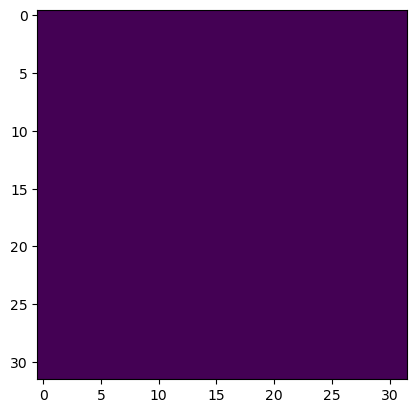

100%|██████████| 10/10 [00:00<00:00, 28.51it/s]


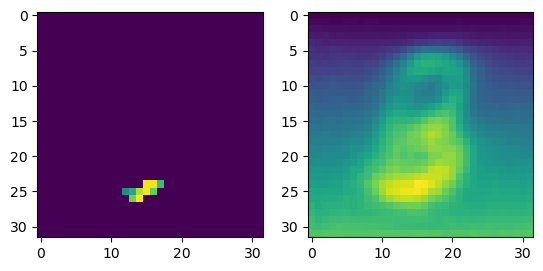

100%|██████████| 10/10 [00:00<00:00, 28.68it/s]


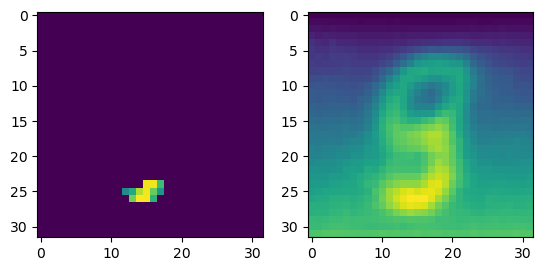

100%|██████████| 10/10 [00:00<00:00, 28.45it/s]


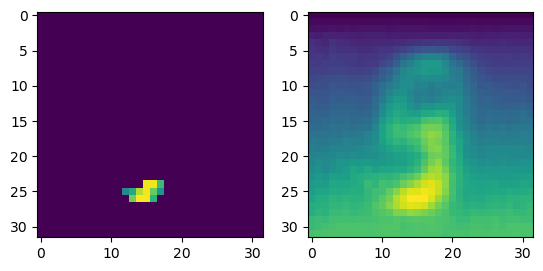

100%|██████████| 10/10 [00:00<00:00, 28.65it/s]


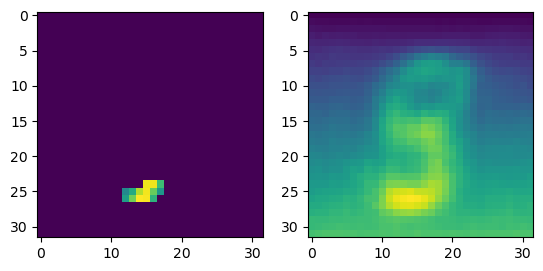

100%|██████████| 10/10 [00:00<00:00, 28.29it/s]


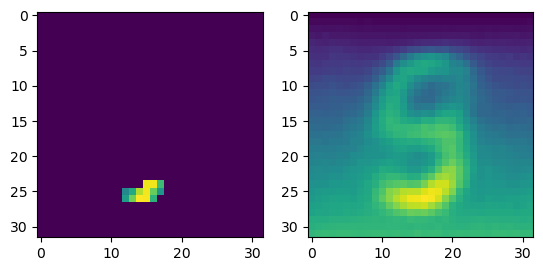

100%|██████████| 10/10 [00:00<00:00, 28.42it/s]


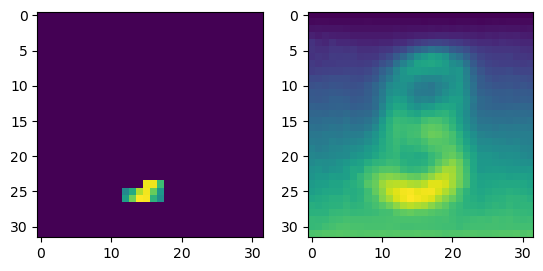

100%|██████████| 10/10 [00:00<00:00, 28.62it/s]


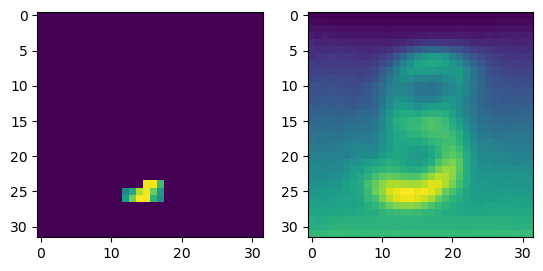

100%|██████████| 10/10 [00:00<00:00, 28.96it/s]


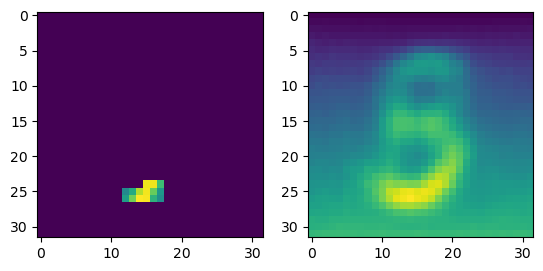

100%|██████████| 10/10 [00:00<00:00, 28.86it/s]


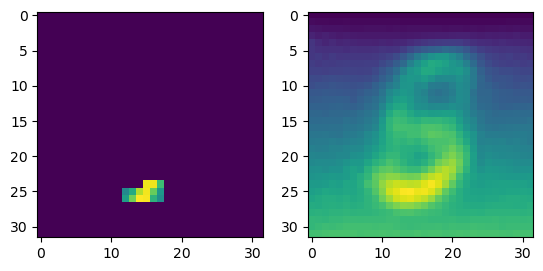

100%|██████████| 10/10 [00:00<00:00, 28.71it/s]


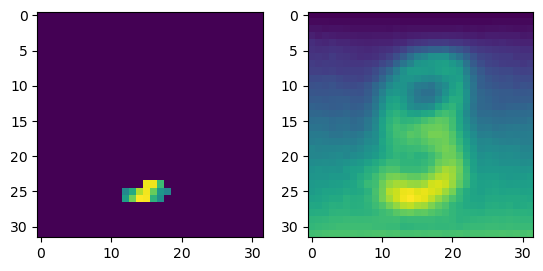

100%|██████████| 10/10 [00:00<00:00, 28.86it/s]


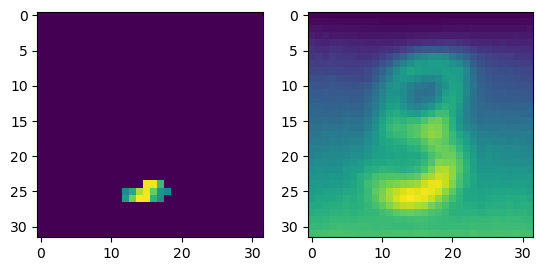

100%|██████████| 10/10 [00:00<00:00, 29.01it/s]


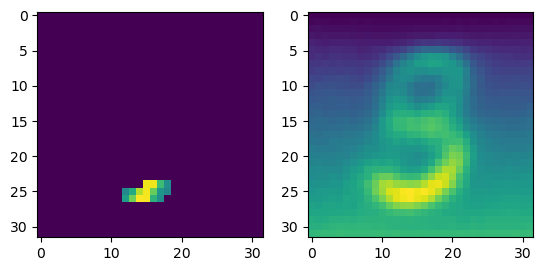

100%|██████████| 10/10 [00:00<00:00, 28.10it/s]


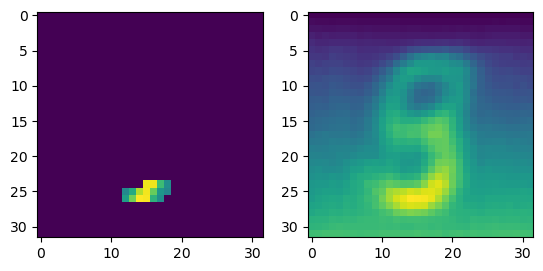

100%|██████████| 10/10 [00:00<00:00, 29.02it/s]


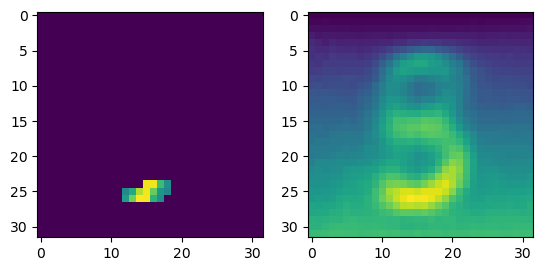

100%|██████████| 10/10 [00:00<00:00, 28.50it/s]


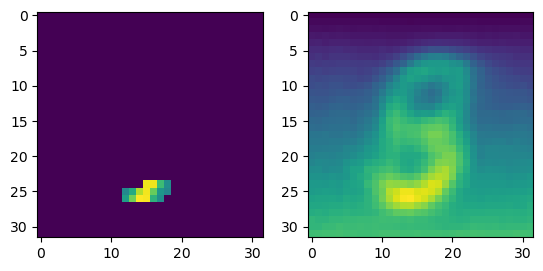

100%|██████████| 10/10 [00:00<00:00, 29.10it/s]


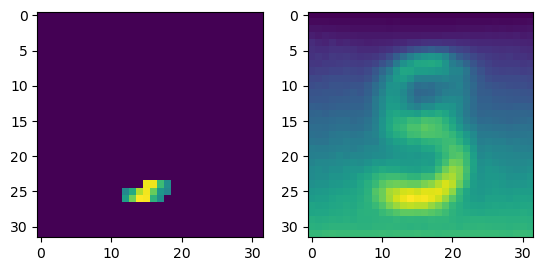

100%|██████████| 10/10 [00:00<00:00, 29.48it/s]


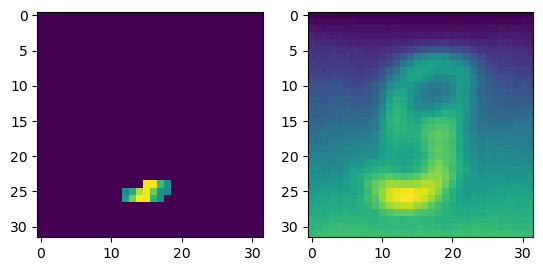

100%|██████████| 10/10 [00:00<00:00, 29.28it/s]


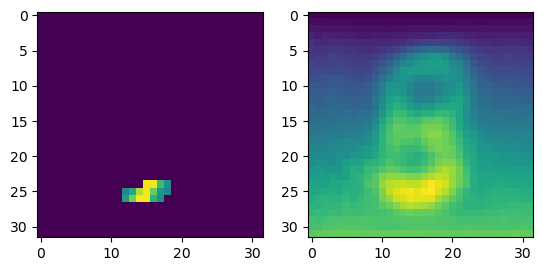

100%|██████████| 10/10 [00:00<00:00, 29.25it/s]


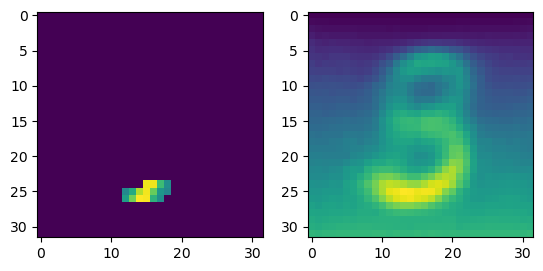

100%|██████████| 10/10 [00:00<00:00, 29.03it/s]


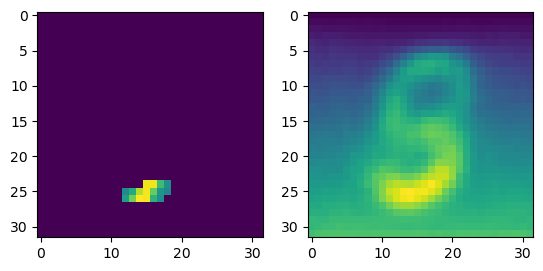

In [20]:
avg_error = thomospon_iteration(x)

In [21]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def ucb_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
    plt.show()
    n_samples = 10
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        A = adapt.ucb_sample(imgs)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        fig, axs= plt.subplots(1, 2)
        axs[0].imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
        axs[1].imshow(rearrange(x_hat.cpu().detach().numpy(), "c h w -> (c h) w" ))
        plt.show()
    return avg_error

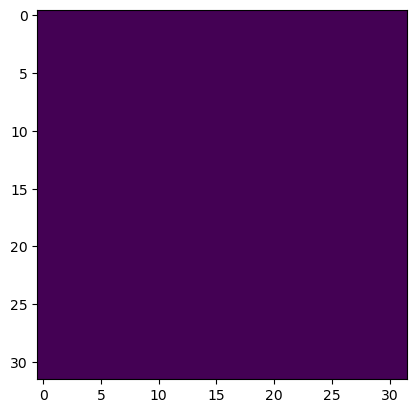

100%|██████████| 10/10 [00:00<00:00, 29.00it/s]


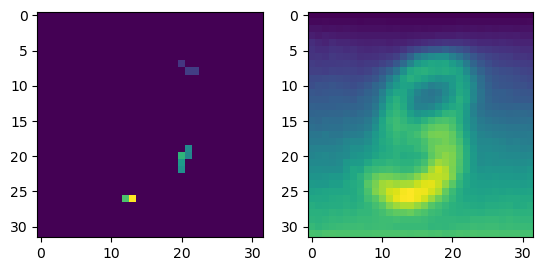

100%|██████████| 10/10 [00:00<00:00, 29.00it/s]


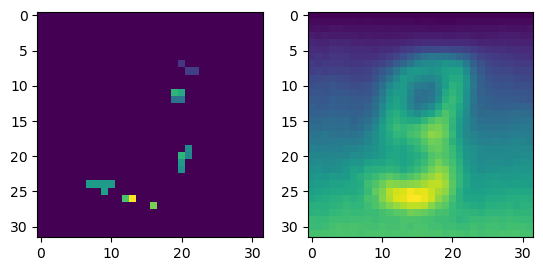

100%|██████████| 10/10 [00:00<00:00, 29.04it/s]


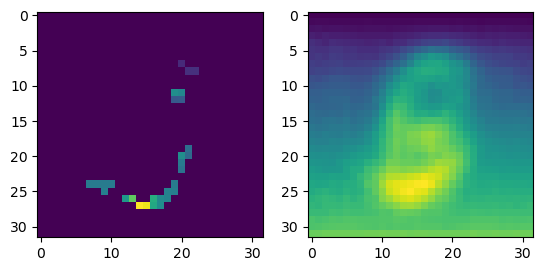

100%|██████████| 10/10 [00:00<00:00, 29.33it/s]


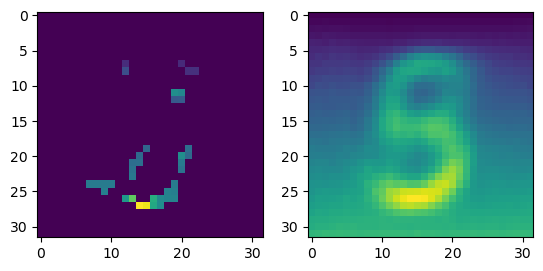

100%|██████████| 10/10 [00:00<00:00, 29.22it/s]


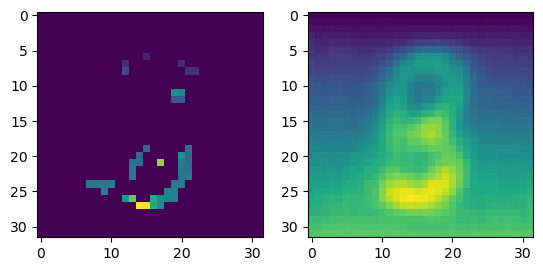

100%|██████████| 10/10 [00:00<00:00, 29.00it/s]


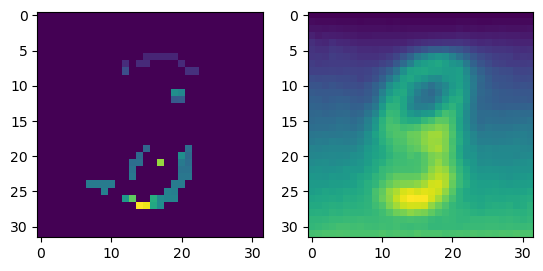

100%|██████████| 10/10 [00:00<00:00, 28.89it/s]


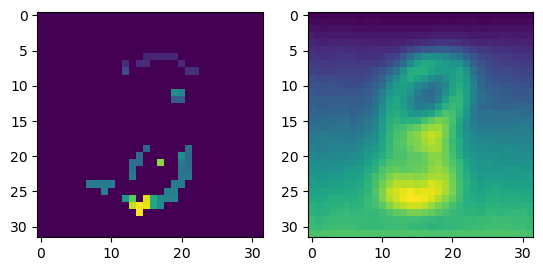

100%|██████████| 10/10 [00:00<00:00, 29.32it/s]


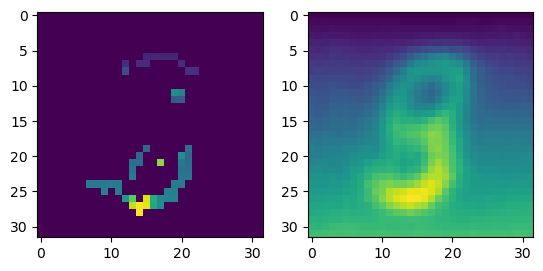

100%|██████████| 10/10 [00:00<00:00, 29.21it/s]


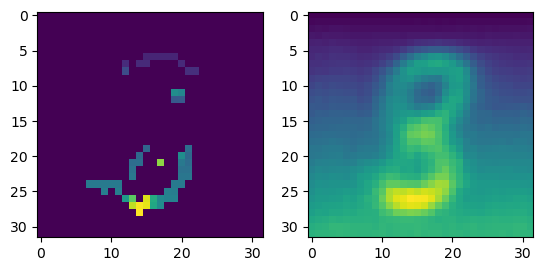

100%|██████████| 10/10 [00:00<00:00, 29.25it/s]


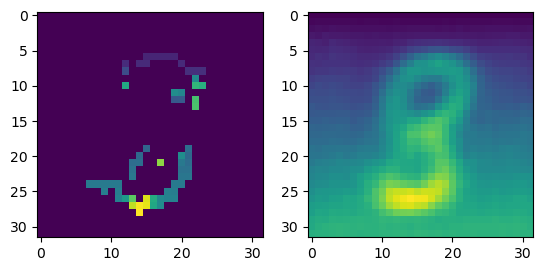

100%|██████████| 10/10 [00:00<00:00, 28.92it/s]


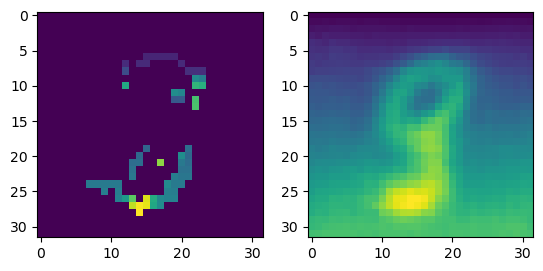

100%|██████████| 10/10 [00:00<00:00, 29.08it/s]


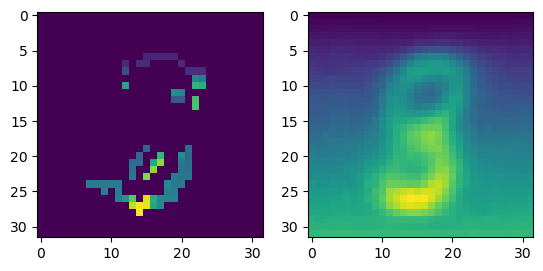

100%|██████████| 10/10 [00:00<00:00, 33.32it/s]


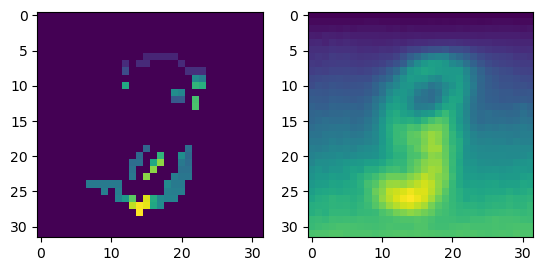

100%|██████████| 10/10 [00:00<00:00, 29.30it/s]


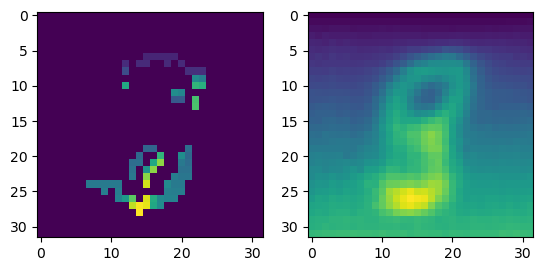

100%|██████████| 10/10 [00:00<00:00, 29.25it/s]


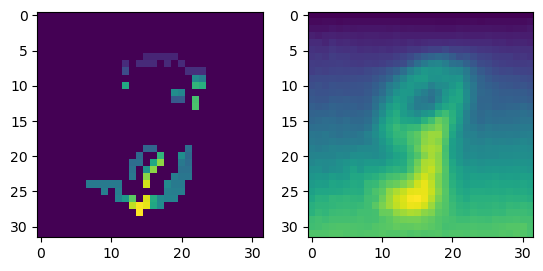

100%|██████████| 10/10 [00:00<00:00, 29.01it/s]


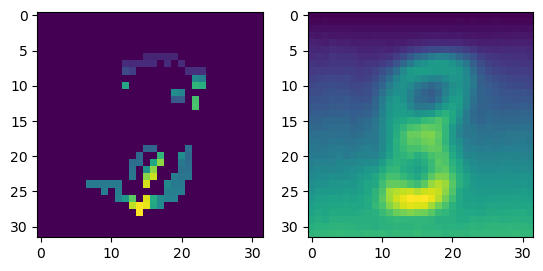

100%|██████████| 10/10 [00:00<00:00, 29.33it/s]


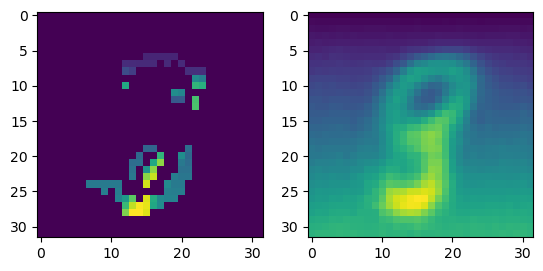

100%|██████████| 10/10 [00:00<00:00, 29.18it/s]


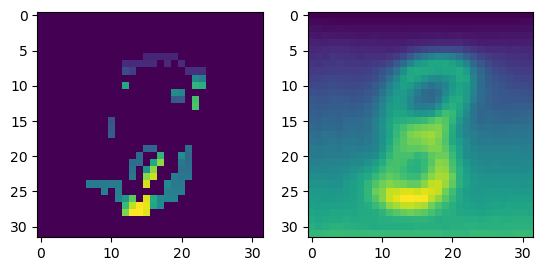

100%|██████████| 10/10 [00:00<00:00, 28.84it/s]


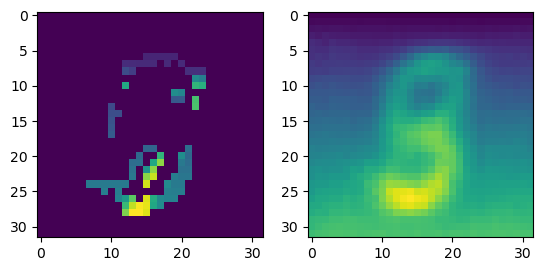

100%|██████████| 10/10 [00:00<00:00, 28.86it/s]


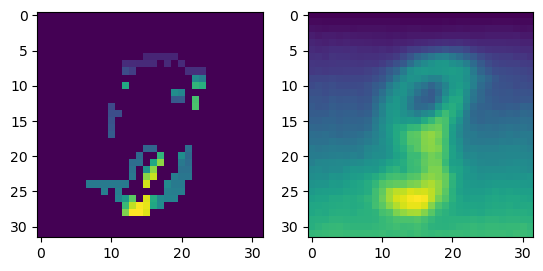

In [22]:
avg_error = ucb_iteration(x)

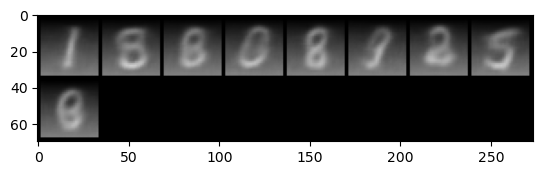

In [13]:
from torchvision.utils import make_grid
plt.imshow(rearrange(make_grid(samples), "c h w -> h w c"))
plt.show()